In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
! pip install pgeocode
import pgeocode
! pip install geopy
import geopy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


# GOAL

We want to predict most suitable products recommendtaion for user based on:
- their 3 favourite product category
- their geolocation: state and city

As an outup we expect 10 products id.

Additional assumptions:

- We don't know user id - we can not use data about previous orders

# Prepare Data

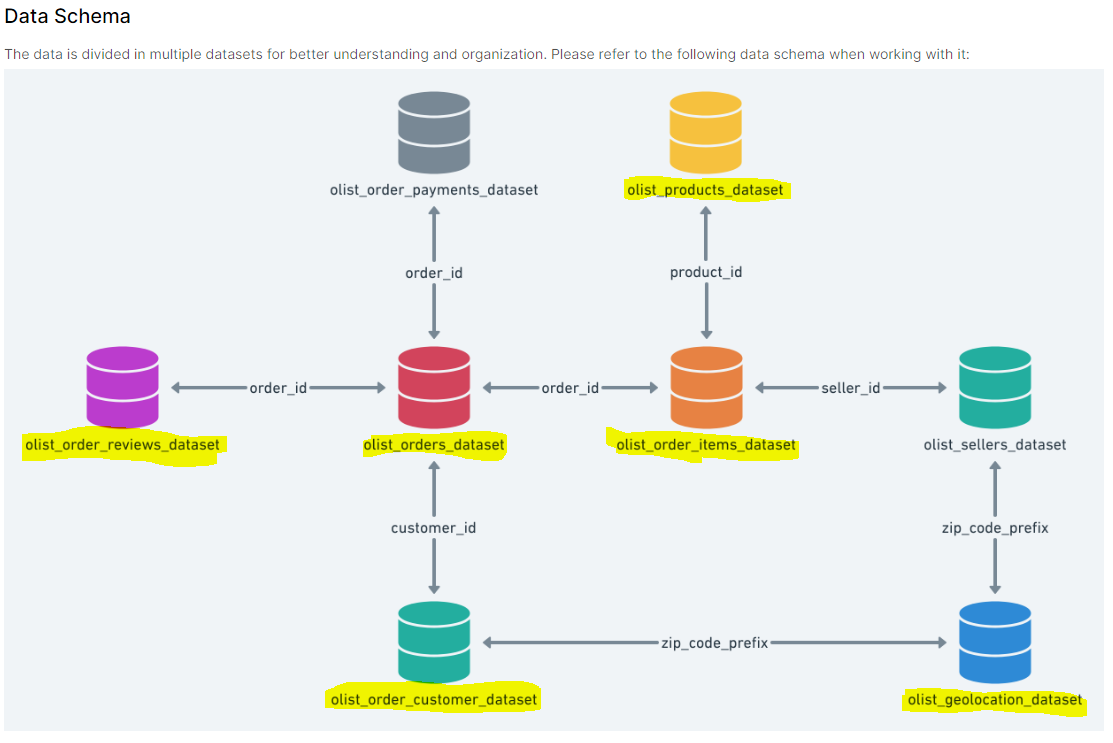

## Get all necessery data and explore it

In [2]:
# Read from csv
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')

# Select only needed columns
products = products[['product_id', 'product_category_name']].dropna()


# Translate product category - not used right now
# prod_category_trans = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
# products = products.merge(prod_category_trans, on='product_category_name')

print(products.isna().sum())
products.describe()

product_id               0
product_category_name    0
dtype: int64


,product_id,product_category_name
count,32341,32341
unique,32341,73
top,0b426fbfa39b2ae1c7a4a12e9b9d104a,cama_mesa_banho
freq,1,3029


Dropped data, which is not classified to specific product_category to have clean data for further processing.

In [3]:
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
orders = orders[['order_id','customer_id', 'order_purchase_timestamp']]

orders.describe()

,order_id,customer_id,order_purchase_timestamp
count,99441,99441,99441
unique,99441,99441,98875
top,3e93213bb8fdda91186b4018b2fe0030,70eb2dbf20da55dcfb3bbe2cb2cf1fe2,2017-11-20 11:46:30
freq,1,1,3


Orders dataframe is one to one relationship between order and customer

1. customer_id --> key to the orders dataset. Each order has a unique customer_id.
2. customer_unique_id --> unique identifier of a customer.

In [4]:
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
customers.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,6375f291ca662cda38bba47ce8d767f1,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


We have only ~3300 users, who ordered more than once.
One user placed max. 17 orders.

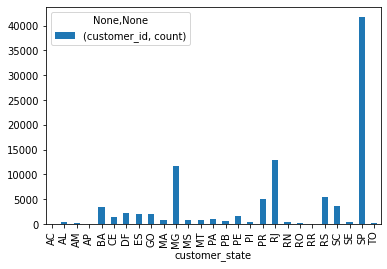

In [5]:
cust_per_state = customers[['customer_id','customer_state']].groupby('customer_state').agg(['count']).plot.bar()

Highly dominant region regarding users activity is Sao Paulo, Rio de Janeiro and Minas Gerais.

In [6]:
geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')

customers = pd.merge(customers, geolocation, how='left', left_on=['customer_zip_code_prefix'], right_on=['geolocation_zip_code_prefix'])
# geolocation dataset has duplicates with zip_code --> we take first occurance as originall longitute and latitude
customers = customers.drop_duplicates(subset='customer_id')
customers = customers[['customer_id', 'customer_unique_id', 'geolocation_lat', 'geolocation_lng']].dropna()

print(customers.shape)
print(customers.isna().sum())
customers.head(3)

(99163, 4)
customer_id           0
customer_unique_id    0
geolocation_lat       0
geolocation_lng       0
dtype: int64


,customer_id,customer_unique_id,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,-20.509897,-47.397866
147,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,-23.726853,-46.545746
325,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,-23.527788,-46.660310


In [7]:
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
order_items = order_items[['order_id', 'order_item_id', 'product_id']]

order_items.describe()

,order_item_id
count,112650.000000
mean,1.197834
std,0.705124
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


Most orders is for just one product.

In [8]:
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
reviews = reviews[['order_id', 'review_score']]

reviews.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


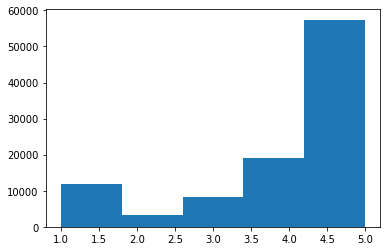

In [9]:
plt.hist(reviews['review_score'], 5)
plt.show()

Reviews distribution is uneven. There is a high disproportion between the number of products rated with 5 and other ratings.
Review is linked with whole order not specific product.

## Merge data to prepare input for processing

In [27]:
# merge customers with orders 
data_input = pd.merge(customers,orders, on='customer_id')
print(data_input.shape)

# merge with order_items
data_input = data_input.merge(order_items, on='order_id')
print(data_input.shape)

# merge with products
data_input = data_input.merge(products, on='product_id')
print(data_input.shape)

# merge with reviews
data_input = data_input.merge(reviews, on='order_id')
print(data_input.shape)
data_input_base = data_input.copy()

(99163, 6)
(112348, 8)
(110751, 9)
(111409, 10)


Check distribution of sold product per product category.

<AxesSubplot:title={'center':'products sold per top 20 category'}, xlabel='product_category_name'>

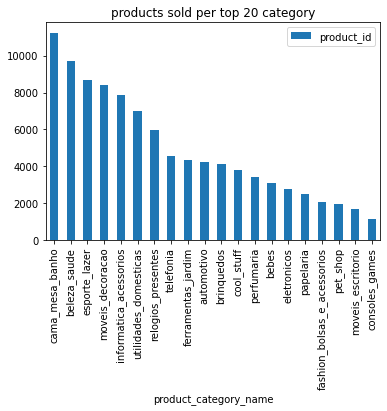

In [25]:
items_per_cat = data_input_base.groupby('product_category_name').agg({'product_id':'count'})
items_per_cat = items_per_cat.sort_values('product_id' ,ascending=False)
items_per_cat.iloc[:20].plot.bar(title='products sold per top 20 category')

# K-Nearest neighbours approach

I will be trying to implement k nearest neighbours approach. At first stage I will try to find similar user with geolocation and product categories. As an input for algorithm distance function calculation i will use:
- geolocation_lat
- geolocation_lng
- user marching score based on shopping cart, which is assigned to given order --> I'm assuming, that person buys product in their favourite category and review is just opinion and finall satisfaction.It doesn't tell us about preferences of the user, just about quality of the product.

At the second stage, when we have neighbours let say 1000 closest users, I will check, which products are bought most frequently and with best reviews and it will be finall sugestion for user.

We don't need customer_unique_id, we will try to link each user's action (custumer_id) to provide best match. If some user (unique id) bought few times similar order to our need, user should appear more time in k nearest nighbour and thus his items shold be taken into consideration,
I will aggregate products to list of produsts assigned to each user_id (same with product category).

At this stage we should have clean complete data with no null values.

In [64]:
data_input = data_input.drop(['customer_unique_id', 'order_id', 'order_item_id'],axis=1)
print(data_input.isna().sum())
data_input.describe(include='all')

customer_id                 0
geolocation_lat             0
geolocation_lng             0
order_purchase_timestamp    0
product_id                  0
product_category_name       0
review_score                0
dtype: int64


,customer_id,geolocation_lat,geolocation_lng,order_purchase_timestamp,product_id,product_category_name,review_score
count,111409,111409.000000,111409.000000,111409,111409,111409,111409.000000
unique,97009,NaN,NaN,96478,32294,73,NaN
top,be1c4e52bb71e0c54b11a26b8e8d59f2,NaN,NaN,2017-10-17 13:06:29,aca2eb7d00ea1a7b8ebd4e68314663af,cama_mesa_banho,NaN
freq,22,NaN,NaN,22,525,11244,NaN
mean,NaN,-21.237421,-46.201812,NaN,NaN,NaN,4.018221
std,NaN,5.575500,4.044153,NaN,NaN,NaN,1.397758
min,NaN,-36.605374,-72.666706,NaN,NaN,NaN,1.000000
25%,NaN,-23.590774,-48.110471,NaN,NaN,NaN,4.000000
50%,NaN,-22.930927,-46.632930,NaN,NaN,NaN,5.000000
75%,NaN,-20.189441,-43.636571,NaN,NaN,NaN,5.000000


## Data transormation

Aggregate products per user.

In [65]:
# User id is one to one match with order id so we can take first geolocation and it will be the same for other products
# The same with review, review is one to one match with order, so we will take first one for all products aggregated

data_input = data_input.groupby('customer_id').agg({'geolocation_lat':'first','geolocation_lng':'first',
                                                    'product_id':lambda x: list(x), 'order_purchase_timestamp': 'first',
                                                    'product_category_name':lambda x: list(x), 'review_score':'first'}).reset_index()

data_input.head()

,customer_id,geolocation_lat,geolocation_lng,product_id,order_purchase_timestamp,product_category_name,review_score
0,00012a2ce6f8dcda20d059ce98491703,-23.499689,-46.766901,[64315bd8c0c47303179dd2e25b579d00],2017-11-14 16:08:26,[brinquedos],1
1,000161a058600d5901f007fab4c27140,-20.470582,-45.108716,[84183944dc7cddca87a5d384452c1d3c],2017-07-16 09:40:32,[beleza_saude],4
2,0001fd6190edaaf884bcaf3d49edf079,-18.716793,-40.397969,[9df2b21ec85378d71df4404712e17478],2017-02-28 11:06:43,[bebes],5
3,0002414f95344307404f0ace7a26f1d5,-21.770599,-43.355230,[af3ec22cce878225aae6d9eb6c7a78eb],2017-08-16 13:09:20,[cool_stuff],5
4,000379cdec625522490c315e70c7a9fb,-23.741140,-46.690509,[868b3136c5b206f91b8208fbfdf2cb7c],2018-04-02 13:42:17,[cama_mesa_banho],4


Scale geolocation data for KNN processing

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_input[['geolocation_lat', 'geolocation_lng']] = scaler.fit_transform(data_input[['geolocation_lat', 'geolocation_lng']])
data_input.head(3)

,customer_id,geolocation_lat,geolocation_lng,product_id,order_purchase_timestamp,product_category_name,review_score
0,00012a2ce6f8dcda20d059ce98491703,0.166338,0.404123,[64315bd8c0c47303179dd2e25b579d00],2017-11-14 16:08:26,[brinquedos],1
1,000161a058600d5901f007fab4c27140,0.204784,0.429997,[84183944dc7cddca87a5d384452c1d3c],2017-07-16 09:40:32,[beleza_saude],4
2,0001fd6190edaaf884bcaf3d49edf079,0.227043,0.503500,[9df2b21ec85378d71df4404712e17478],2017-02-28 11:06:43,[bebes],5


We create user_match_score metric, which will be thrid component of the vector for distance calculation in KNN.
After several tests review_score will be taken into account in calculation. We want to find satisfied neighbours :)

In [68]:
def apply_user_match_score(product_categories, user_categories):
    score1 = 0
    score2 = 0
    # Check if product_category in cart matches user prefernces - 1.0 means all products are in intrest range
    for cat in product_categories:
        if cat in user_categories:
            score1 += 1
    score1 = score1 / len(product_categories)
    
    # Check if all categories are covered by cart - 1.0 means cart has all 3 of favourite usere's categories
    for cat in user_categories:
        if cat in product_categories:
            score2 += 1
    score2 = score2 / len(user_categories)
    
    return (score1+score2)/2

## User input - provide data of user to get product recommendation

In [77]:
user2 = [('cama_mesa_banho', 'papelaria', 'fashion_calcados'), ('sao paulo', 'SP')]
user1 = [('esporte_lazer', 'moveis_decoracao', 'telefonia'), ('rio de janeiro', 'RJ')]

categories = user1[0]

To localize user we will use geolocation database and find mean values for user's city (try to find center).

In [78]:
user_geo = geolocation[geolocation['geolocation_city'] == user1[1][0]]
user_lat = user_geo['geolocation_lat'].mean() 
user_lng = user_geo['geolocation_lng'].mean()
user_loc = [user_lat, user_lng]
user_loc = scaler.transform([user_loc])[0]

# user dataframe - match_score = 1.0 becouse we want to find best fit regarding product category
data = {'geolocation_lat': user_loc[0], 'geolocation_lng': user_loc[1], 'user_match_score':[1.0]}  
test_user = pd.DataFrame(data)
print(test_user)

   geolocation_lat  geolocation_lng  user_match_score
0          0.17376         0.458018               1.0


In [79]:
# Count review score into metric
data_input['user_match_score'] = data_input['product_category_name'].apply(lambda x: apply_user_match_score(x,categories))*data_input['review_score']/5
data_input.head()

,customer_id,geolocation_lat,geolocation_lng,product_id,order_purchase_timestamp,product_category_name,review_score,user_match_score
0,00012a2ce6f8dcda20d059ce98491703,0.166338,0.404123,[64315bd8c0c47303179dd2e25b579d00],2017-11-14 16:08:26,[brinquedos],1,0.0
1,000161a058600d5901f007fab4c27140,0.204784,0.429997,[84183944dc7cddca87a5d384452c1d3c],2017-07-16 09:40:32,[beleza_saude],4,0.0
2,0001fd6190edaaf884bcaf3d49edf079,0.227043,0.503500,[9df2b21ec85378d71df4404712e17478],2017-02-28 11:06:43,[bebes],5,0.0
3,0002414f95344307404f0ace7a26f1d5,0.188284,0.457357,[af3ec22cce878225aae6d9eb6c7a78eb],2017-08-16 13:09:20,[cool_stuff],5,0.0
4,000379cdec625522490c315e70c7a9fb,0.163274,0.405315,[868b3136c5b206f91b8208fbfdf2cb7c],2018-04-02 13:42:17,[cama_mesa_banho],4,0.0


In [72]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

Fit KNN to find similar user regarding geolocation and product category match.

In [80]:
# Select mdoel
knn = NearestNeighbors(n_neighbors=10000, algorithm='ball_tree')

# Train test split 20% for testing 
X_train, X_test, y_train, y_test = train_test_split(data_input, data_input['product_id'], test_size=0.2, random_state=42)

# Fit model to our data
knn.fit(X_train[['geolocation_lat', 'geolocation_lng', 'user_match_score']])

# Make point predictions on the test set using the fit model.
distances, indices = knn.kneighbors([test_user.iloc[0]])
X_matched = X_train.iloc[indices[0]]
X_matched.head()                                   

,customer_id,geolocation_lat,geolocation_lng,product_id,order_purchase_timestamp,product_category_name,review_score,user_match_score
2598,06d338952a08988a496796c25a61d12d,0.172772,0.455905,"[f48eb5c2fde13ca63664f0bb05f55346, fa9cf28beaa...",2017-09-11 11:41:16,"[esporte_lazer, moveis_decoracao]",5,0.833333
23831,3ebd3326c483aa9a6615659a8039b0b9,0.174000,0.457882,"[ee506a406849de8c60a4bceb731e7832, ee506a40684...",2018-05-15 01:57:02,"[esporte_lazer, esporte_lazer]",5,0.666667
34338,5ad1e88a2aa6f14c0aee6d2f1fdd5550,0.174000,0.457882,"[ee92961b88199a0d4329a6beca8f63da, ee92961b881...",2017-08-09 22:31:26,"[esporte_lazer, esporte_lazer]",5,0.666667
21857,39794e843253693e05251852876efc86,0.174003,0.457863,[55b71bf300a2765a382eaec566df531f],2018-06-13 11:40:00,[esporte_lazer],5,0.666667
58513,9a47578c78d75440172d1a7756850868,0.174003,0.457863,[7c7588d9c0e7596f400f129e8bfecb03],2017-06-22 20:02:58,[esporte_lazer],5,0.666667


We have similar users, lets group product and check bestsellers.

<AxesSubplot:title={'center':'Sold items per category group in proposed neighbourhood'}, xlabel='product_category_name_y'>

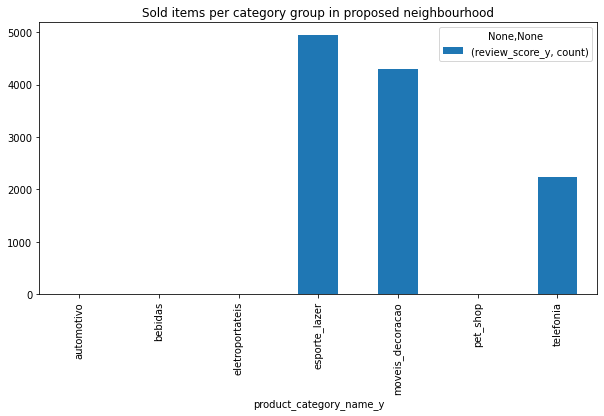

In [81]:
# Merge with base data from previous stages
products_fit = pd.merge(X_matched, data_input_base, how='left', left_on=['customer_id'], right_on=['customer_id'])

prod_cat_fit = products_fit[['product_category_name_y', 'review_score_y']]
prod_cat_fit.groupby('product_category_name_y').agg(['count']).plot.bar(title='Sold items per category group in proposed neighbourhood')

In [82]:
product_filtered = products_fit[['product_id_y', 'product_category_name_y', 'review_score_y']]
product_filtered = product_filtered.groupby(['product_id_y', 'product_category_name_y']).agg(['count', 'mean'])
product_filtered = product_filtered.sort_values([('review_score_y', 'count')],ascending=False)

print(product_filtered.shape)
product_filtered.head(10)

(4495, 2)


review_score_y  \
                                                                  count   
product_id_y                     product_category_name_y                  
aca2eb7d00ea1a7b8ebd4e68314663af moveis_decoracao                   286   
b532349fe46b38fbc7bb3914c1bdae07 moveis_decoracao                    72   
9ecadb84c81da840dbf3564378b586e9 moveis_decoracao                    62   
78efe838c04bbc568be034082200ac20 moveis_decoracao                    58   
c6336fa91fbd87c359e44f5dca5a90ed esporte_lazer                       54   
e44f675b60b3a3a2453ec36421e06f0f esporte_lazer                       46   
11875b30b49585209e608f40e8082e65 esporte_lazer                       45   
d3c044bd42d84a79e3b0c42662806a48 esporte_lazer                       42   
eb8c629f70275fd1c4f809116cce1efc moveis_decoracao                    38   
c7fd13b5e515bffdab855d0812842edb moveis_decoracao                    36   

                                                                    
                                                              mean  
product_id_y                     product_category_name_y            
aca2eb7d00ea1a7b8ebd4e68314663af moveis_decoracao         4.762238  
b532349fe46b38fbc7bb3914c1bdae07 moveis_decoracao         4.986111  
9ecadb84c81da840dbf3564378b586e9 moveis_decoracao         4.516129  
78efe838c04bbc568be034082200ac20 moveis_decoracao         4.896552  
c6336fa91fbd87c359e44f5dca5a90ed esporte_lazer            4.870370  
e44f675b60b3a3a2453ec36421e06f0f esporte_lazer            4.847826  
11875b30b49585209e608f40e8082e65 esporte_lazer            4.844444  
d3c044bd42d84a79e3b0c42662806a48 esporte_lazer            4.880952  
eb8c629f70275fd1c4f809116cce1efc moveis_decoracao         4.657895  
c7fd13b5e515bffdab855d0812842edb moveis_decoracao         4.611111

For the user we will propose equally 3x best seller for each category intrested and one random from other products categories. User might be also intrested in something else, which similar user bought.

In [ ]:
print(categories[0])
#print(product_filtered.iloc[:,0])
product_filtered.droplevel(1)
print(product_filtered.columns)
#prod_cat1 = product_filtered[product_filtered['product_category_name_y'] == categories[0]]
#prod_cat1.head(3)

# Cold start problem - anonymous user

Lets check whether productgroup activity productgroup activity dependen on time. First plot shows product group without time filtering

<AxesSubplot:title={'center':'products sold per top 20 category'}, xlabel='product_category_name'>

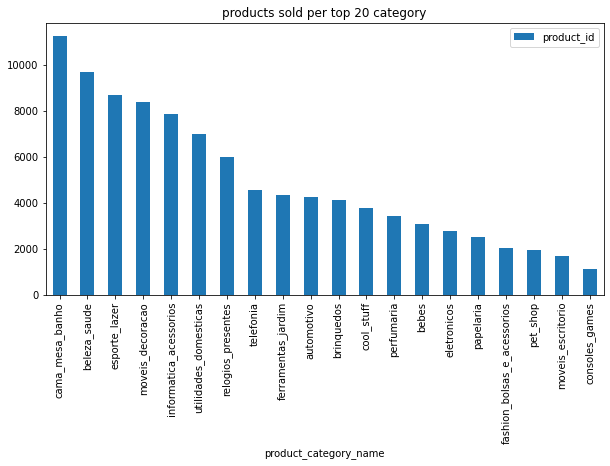

In [43]:
items_per_cat = data_input_base.groupby('product_category_name').agg({'product_id':'count'})
items_per_cat = items_per_cat.sort_values('product_id' ,ascending=False)
items_per_cat.iloc[:20].plot.bar(title='products sold per top 20 category')

In [37]:
data_input_base.head(3)

,customer_id,customer_unique_id,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,order_item_id,product_id,product_category_name,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,-20.509897,-47.397866,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio,4
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio,1
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio,1


By weekday --> 2018-08-27 --> Monday

<AxesSubplot:xlabel='product_category_name'>

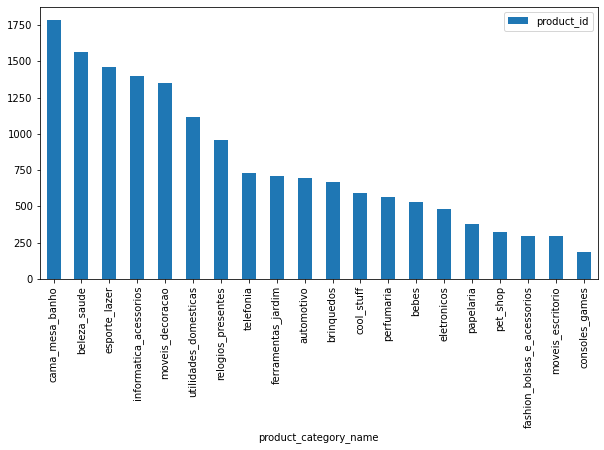

In [42]:
import matplotlib 

matplotlib.rcParams['figure.figsize'] = [10, 5]
data_input_base['order_purchase_timestamp'] = pd.to_datetime(data_input_base['order_purchase_timestamp'])
filtered_by_dow = data_input_base[data_input_base['order_purchase_timestamp'].dt.weekday == 0]
filtered_by_dow.groupby(data_input_base['product_category_name']).agg({'product_id':'count'}).sort_values('product_id' ,ascending=False).iloc[:20].plot.bar()

By month. We consider 8th month - 2018-08-27

<AxesSubplot:xlabel='product_category_name'>

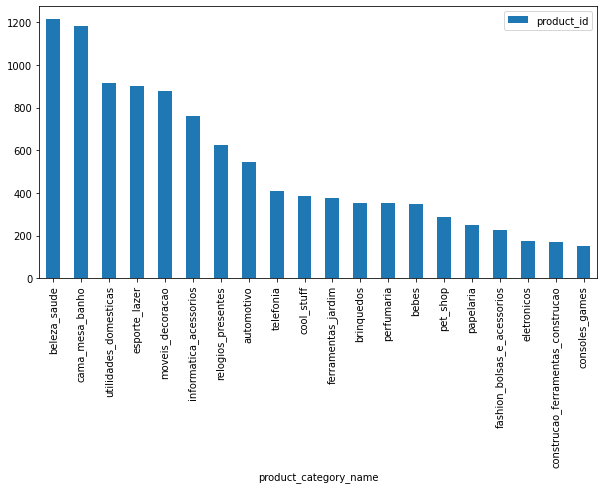

In [59]:
filtered_by_month = data_input_base[data_input_base['order_purchase_timestamp'].dt.month == 8]
filtered_by_month.groupby(data_input_base['product_category_name']).agg({'product_id':'count'}).sort_values('product_id' ,ascending=False).iloc[:20].plot.bar()

On monday pattern looks really similar to the basic one. Filtering by month shows just slight shift of popularity between coma_mesa_bahno and beleza_saude.

Lets check just this last/day/week/month acticity.

<AxesSubplot:xlabel='product_category_name,product_id'>

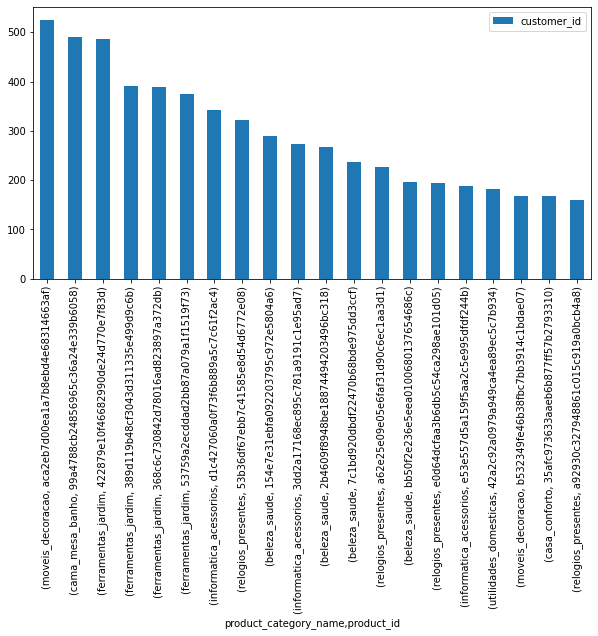

In [83]:


filtered = data_input_base[data_input_base['order_purchase_timestamp'] <= ' 2018-08-27']
anonymous_user = filtered.groupby([data_input_base['product_category_name'], data_input_base['product_id']]).agg({'customer_id':'count'}).sort_values('customer_id' ,ascending=False).iloc[:20]
anonymous_user.plot.bar()

In [84]:
anonymous_user.head(10)

customer_id
product_category_name  product_id                                   
moveis_decoracao       aca2eb7d00ea1a7b8ebd4e68314663af          525
cama_mesa_banho        99a4788cb24856965c36a24e339b6058          490
ferramentas_jardim     422879e10f46682990de24d770e7f83d          486
                       389d119b48cf3043d311335e499d9c6b          391
                       368c6c730842d78016ad823897a372db          388
                       53759a2ecddad2bb87a079a1f1519f73          375
informatica_acessorios d1c427060a0f73f6b889a5c7c61f2ac4          342
relogios_presentes     53b36df67ebb7c41585e8d54d6772e08          322
beleza_saude           154e7e31ebfa092203795c972e5804a6          290
informatica_acessorios 3dd2a17168ec895c781a9191c1e95ad7          274